# Youtube Analysis 
Proof of concept project for analysing the sentiment of videos returned by searching for a key word (i.e. product name). 

Initial implimentation uses NLP to assess the polarity of comments for each video combining this with other metrics to return an overall sentiment score.

Future additions will integrate a company product list and security identifiers to link companies/ tickers to sentiment scores, allowing for statistical assessment of it's predictive power with regards to stock price.


## Setup

1. Create Youtube Data API key as per the instructions [here](https://developers.google.com/youtube/v3/getting-started) 

2. Create `.env` file containing the key as follows: `YT_API_KEY=[key]`
   
3. Finally, after installing SpaCy in your environment, ensure the language library is installed by running the below command in the terminal:

```shell
                                        spacy download en_core_web_sm
```

#### Dependencies

In [1]:
import os
import pandas as pd

import database
from data_api import youtube
from helpers import dict_search, min_max_scaler

##### Import Google Data API Key and Initiate Youtube API Class Instance


In [2]:
# Import env variables and set API key
from dotenv import load_dotenv # Needed to insure .env file imported into jupyter env
load_dotenv() 

DEVELOPER_KEY = os.environ.get('YT_API_KEY')


# Create YouTube Data API object
yt = youtube(DEVELOPER_KEY)

## Search
Run a search using the key term, returning the IDs of relevant videos ordered by upload date.

In [3]:
# Enter keyword below:
keyword = 'macbook' # Macbook as an example

In [4]:
# Use search method to retrieve IDs
response = yt.search(keyword, order='date')
raw_ids = dict_search(response, ["videoId"], list_depth=2)
ids = [row['videoId'] for row in raw_ids]

In [5]:
# Retrieve general information for each video
raw_stats = yt.video_stats(ids)
clean_stats = dict_search(raw_stats, [
    "id", 
    "title",
    "decription", 
    "channelTitle",
    "channelId", 
    "categoryId", 
    "viewCount", 
    "likeCount", 
    "commentCount", 
    "publishedAt"], list_depth=2)
stats_df = pd.DataFrame(clean_stats)
stats_df.head(5)

,id,publishedAt,channelId,title,channelTitle,categoryId,viewCount,likeCount,commentCount
0,_oLTkqiehAk,2022-02-06T17:30:48Z,UChjRM_qQAaOAiLNbOGbYcRA,2022 M2 MacBook Pro First Details - Apple is m...,9to5Mac,28,2663,158,16
1,VcxX1-qn6NQ,2022-02-06T15:00:12Z,UCtCPnSDNWa1i7KFYQxRzaoQ,Que MacBook Air comprar en 2022?,Rodri Royg,28,677,93,20
2,Ss2bh_tBMn0,2022-02-06T15:00:15Z,UCRU9gfeM85WxFqxJFrDsCFQ,"MUST HAVE Apps on M1 Pro MacBook Pro 16""",Cole Caccamise,28,91,13,10
3,7zC4yI3KUvI,2022-02-06T15:00:12Z,UCT5DzezG43sRlcZgxvlP1eA,M1 Max işlemcili 16'' Macbook Pro Kutu Açılımı...,GoldPunch,28,41,9,4
4,i9Pgv6M6el8,2022-02-06T14:39:43Z,UC7zA75VM2OxhHEzirU2oVQg,Macbook Pro 14 after 2 Months - The PROS and t...,W2Best Tech,28,115,18,4


In [6]:
# Retrieve top level comment threads for each video to be used to guage polarity
raw_comments = yt.commentThread(ids)
comments = dict_search(raw_comments, [
    "videoId",
    "textDisplay",
    "publishedAt"
    ], list_depth=2)
comments_df = pd.DataFrame(comments)

In [7]:
# Rename id, comments and comment publishedAt columns and merge with stats dataframe
stats_df.rename(columns={'id':'videoId'}, inplace=True)
comments_df.rename(columns={'textDisplay':'comment', 'publishedAt':'commentDate'}, inplace=True)
merged_df = pd.merge(stats_df, comments_df, how='left', on='videoId')
merged_df['comment'].fillna('', inplace=True)

In [8]:
# Retrieve channel stats for each video and merge with other dataframe
raw_channelStats = yt.channel(stats_df['channelId'].to_list(), part="statistics")
channelStats = dict_search(raw_channelStats, [
    "id", 
    "subscriberCount", 
    "videoCount"
    ], list_depth=2)
channel_df = pd.DataFrame(channelStats)

# Rename ID column and merge
channel_df.rename(columns={'id':'channelId'}, inplace=True)
merged_df = pd.merge(merged_df, channel_df, how='left', on='channelId')

## Sentiment Analysis


In [9]:
# Import sentiment object for analysis
from analysis import sentiment

# Analyse each comment and give polarity score
# 1: Positive, 0: Neutral, -1: Negative
comment_list = merged_df['comment'].astype(str).to_list()
s = sentiment(comment_list)
merged_df['comment_polarity'] = s.polarity()

In [ ]:
# amend data type in count columns from string to integers
merged_df[['likeCount', 'viewCount', 'commentCount', 'subscriberCount']] = merged_df[['likeCount', 'viewCount', 'commentCount', 'subscriberCount']].astype(int)
for column in ['publishedAt', 'commentDate']:
    merged_df[column] = merged_df[column].astype('datetime64').dt.normalize()

df = merged_df.copy()

# Polarity scaled by comment count
df['comment_polarity'] /= df['commentCount']

df['view_sub_ratio'] = df['viewCount'] / df['subscriberCount']
df['like_view_ratio'] = df['likeCount'] / df['viewCount']
df['comment_view_ratio'] = df['commentCount'] / df['viewCount']

### Create Comment Polarity Time Series
Exploratory analysis of comment sentiment (all comments across all videos). Normalisation has been used to assess the polarity of the specific time period, and overlayed with the volume of comments.

In [ ]:
import matplotlib.pyplot as plt

# Sentiment time series
time_series = df.copy()
time_series = time_series.groupby('commentDate').agg(polarity=('comment_polarity','mean'), count = ('commentDate','size')).reset_index()
time_series.fillna(0, inplace=True)

In [ ]:
# Normalise comment polarity
time_series['polarity'] = min_max_scaler(time_series['polarity'])
time_series.set_index('commentDate', inplace=True)

<AxesSubplot:xlabel='commentDate'>

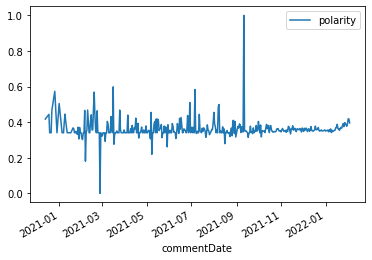

In [ ]:
time_series.plot(y='polarity')

We assess that sentiment can be summarised by: <br>
<br>
$\text{Sentiment} = \dfrac{\sum\text{Comment Polarity}}{\text{Video comment Count}} \times \dfrac{\text{Video Views}}{\text{Channel Subscribers}}$

In [ ]:

# Groupby, summing polarity of comments for each video ID
df = df.groupby(['videoId','view_sub_ratio', 'like_view_ratio', 'comment_view_ratio', 'subscriberCount']).agg({'comment_polarity':['sum']}).reset_index()
df.columns = df.columns.droplevel(1)

# Create video sentiment score
df['sentiment'] = df['comment_polarity']*df['view_sub_ratio']

df.head(5)


## Stock Price Predictive Power

\*\*TODO\*\*